In [25]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
df = pd.read_csv(
    "data/raw/vietnam-weather.csv",
    parse_dates=["date"],
    index_col="date"
)
df.head(20)

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure
date,,,,,,,,,
2009-01-01,Bac Lieu,27,22,17,NNE,6.9,90,71,1010
2010-01-01,Bac Lieu,31,25,20,ENE,0.0,64,24,1010
2011-01-01,Bac Lieu,29,24,14,E,0.0,75,45,1008
2012-01-01,Bac Lieu,30,24,30,E,0.0,79,52,1012
2013-01-01,Bac Lieu,31,25,20,ENE,0.0,70,24,1010
2014-01-01,Bac Lieu,28,23,14,ENE,0.0,75,55,1012
2015-01-01,Bac Lieu,29,23,10,ENE,0.4,75,42,1012
2016-01-01,Bac Lieu,32,24,22,ENE,0.0,63,9,1015
2017-01-01,Bac Lieu,30,24,20,ENE,0.5,76,35,1011


In [35]:
df = df.drop(
    columns=["province", "wind_d", "cloud", "pressure", "humidi"],
    errors="ignore"
)
df = df.rename(columns={
    "max": "t_max",
    "min": "t_min",
    "wind": "wind_speed",
    "rain": "rain",
})

df.head(10)


,t_max,t_min,wind_speed,rain
date,,,,
2009-01-01,27,22,17,6.9
2010-01-01,31,25,20,0.0
2011-01-01,29,24,14,0.0
2012-01-01,30,24,30,0.0
2013-01-01,31,25,20,0.0
2014-01-01,28,23,14,0.0
2015-01-01,29,23,10,0.4
2016-01-01,32,24,22,0.0
2017-01-01,30,24,20,0.5


In [37]:
numeric_cols = ["t_max", "t_min", "wind_speed", "rain",]

df[numeric_cols] = df[numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)

In [38]:
missing_percent = df.isna().mean() * 100
missing_percent

t_max         0.0
t_min         0.0
wind_speed    0.0
rain          0.0
dtype: float64

In [39]:
df["rain"].describe()


count    181960.000000
mean          6.210872
std          10.505083
min           0.000000
25%           0.100000
50%           1.800000
75%           7.500000
max          59.700000
Name: rain, dtype: float64

this looks realistic for Vietnam

Median (50%) = 1.8 mm → many light-rain days

25% = 0.1 mm → very dry days
75% = 7.5 mm → normal rain
Max = 596.4 mm → extreme monsoon / storm day

Vietnam does get 300–600 mm/day during extreme events.

In [40]:
rain_cap = df["rain"].quantile(0.99)
df["rain"] = df["rain"].clip(0, rain_cap)
df["rain"].describe()

count    181960.000000
mean          6.210872
std          10.505083
min           0.000000
25%           0.100000
50%           1.800000
75%           7.500000
max          59.700000
Name: rain, dtype: float64

In [43]:
df.to_csv("data/processed/vietnam_weather_processed.csv", index=True)

In [ ]:
features = df[
    [ "t_max", "t_min", "wind_speed", "rain"]
]

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


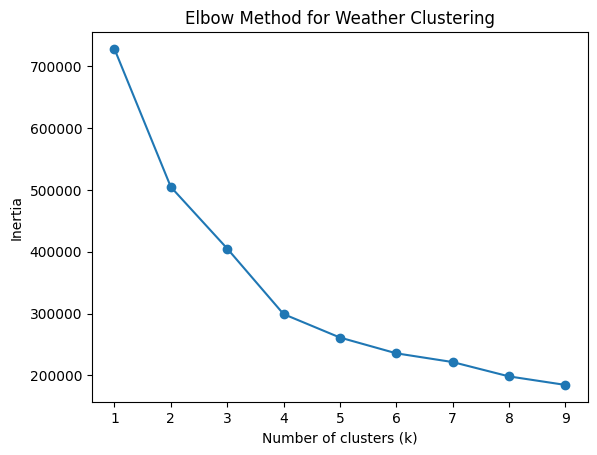

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 10), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Weather Clustering")
plt.show()

In [46]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)


In [47]:
df.groupby("cluster")[[
    "t_max",
    "t_min",
    "wind_speed",
    "rain"
]].mean()


,t_max,t_min,wind_speed,rain
cluster,,,,
0,30.268596,24.941464,18.253095,6.951542
1,32.112457,24.919059,8.655393,6.709853
2,23.529705,17.227189,9.138999,4.110608


# Phân loại các cluster
## Cluster 2
t_max ≈ 23.5 \
t_min ≈ 17.2 \
rain ≈ 4.1 \
wind ≈ 9.1 


Có nhiệt độ lạnh nhất \
Mưa ít nhất 
Đây rõ ràng là ngày khô ( Dry ) 

## Cluster 0
t_max ≈ 30.3 \
t_min ≈ 24.9 \
rain ≈ 7.0   \
wind ≈ 18.3  


Ấm \
Mưa nhiều \
Gió mạnh
Phù hợp với ngày ẩm ( Wet ) \


## Cluster 1
t_max ≈ 32.1 \
t_min ≈ 24.9 \
rain ≈ 6.7 \
wind ≈ 8.7 

Nóng \
Mưa bình thường \
Gió nhe 
Loại này phù hợp với ngày bình thường ( NORMAL ) \



In [48]:
cluster_map = {
    0: "Wet",
    1: "Normal",
    2: "Dry"
}

df["condition"] = df["cluster"].map(cluster_map)


In [49]:
df[["cluster", "condition"]].head()


,cluster,condition
date,,
2009-01-01,0,Wet
2010-01-01,0,Wet
2011-01-01,0,Wet
2012-01-01,0,Wet
2013-01-01,0,Wet


In [50]:
df["condition"].value_counts(normalize=True) * 100


condition
Normal    54.841174
Wet       23.753023
Dry       21.405803
Name: proportion, dtype: float64

In [52]:
import joblib

joblib.dump(scaler, "models/weather_scaler.joblib")
joblib.dump(kmeans, "models/weather_kmeans.joblib")


['models/weather_kmeans.joblib']